# Amsterdam House Prices Prediction
This project aims to predict house prices in Amsterdam using various regression models. The dataset used is from August 2021 and contains information about house prices, area, number of rooms, and geographic coordinates.



### Imports
We start by importing necessary libraries for data manipulation, visualization, and modeling.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### DATA EXPLORATION
We load the dataset and perform some initial exploration to understand the structure of the data and check for any missing values.

   Unnamed: 0                                 Address      Zip     Price  \
0           1            Blasiusstraat 8 2, Amsterdam  1091 CR  685000.0   
1           2  Kromme Leimuidenstraat 13 H, Amsterdam  1059 EL  475000.0   
2           3              Zaaiersweg 11 A, Amsterdam  1097 SM  850000.0   
3           4            Tenerifestraat 40, Amsterdam  1060 TH  580000.0   
4           5              Winterjanpad 21, Amsterdam  1036 KN  720000.0   

   Area  Room       Lon        Lat  
0    64     3  4.907736  52.356157  
1    60     3  4.850476  52.348586  
2   109     4  4.944774  52.343782  
3   128     6  4.789928  52.343712  
4   138     5  4.902503  52.410538  
There are 4 missing values in the Dataframe!
Index(['Address', 'Zip', 'Price', 'Area', 'Room', 'Lon', 'Lat'], dtype='object')
Column Address has 0 missing values
Column Zip has 0 missing values
Column Price has 4 missing values
Column Area has 0 missing values
Column Room has 0 missing values
Column Lon has 0 missing va

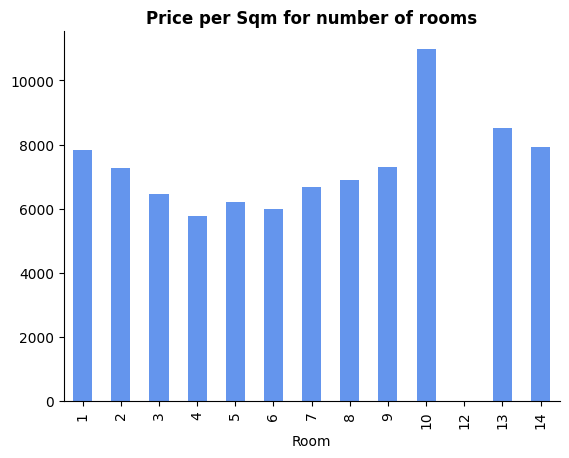

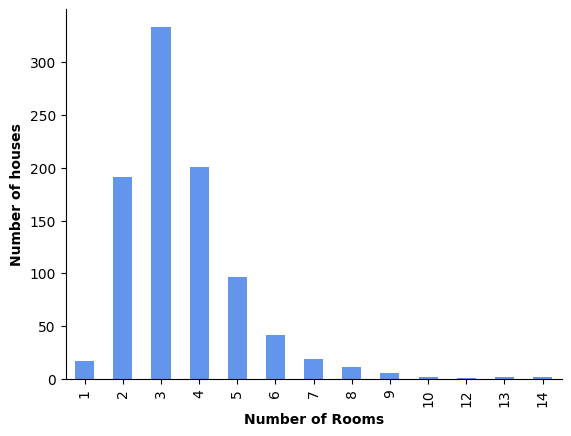

In [2]:
house_data = pd.read_csv('HousingPrices-Amsterdam-August-2021.csv')
print(house_data.head())

# check for nan-values in the whole dataframe
missing_values = house_data.isnull().sum().sum()
print('There are %s missing values in the Dataframe!' %(missing_values))
#remove unessecary columns
house_data = house_data.loc[:, ~house_data.columns.str.contains('^Unnamed')] 

# check for nan in all coloumns
cols = house_data.columns
print(cols)

for col in cols:
    temp = house_data[col].isnull().values.sum()
    print(f'Column {col} has {temp} missing values')

house_data.dropna()

#Price per square meter
house_data['PriceSqm'] = house_data.Price / house_data.Area 
house_data['PriceSqm'] = house_data['PriceSqm'].round(2)
# Visualize the price per squaremeter for every number of rooms 
room_sqm = house_data.groupby('Room').PriceSqm.mean()
room_sqm.plot.bar()
plt.title("Price per Sqm for number of rooms", weight='bold')
ax = room_sqm.plot.bar(color='cornflowerblue')

# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Show the plot
plt.show()

# visualize the distribution how many houses have how many rooms 
houses_rooms = house_data.groupby('Room').size()
ax =houses_rooms.plot.bar(color='cornflowerblue')
plt.ylabel("Number of houses", weight ='bold')
plt.xlabel("Number of Rooms", weight ='bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()


### DATA PROCESSING

In [3]:
numeric_data = house_data.select_dtypes(include=['number'])
numeric_data = numeric_data.dropna()

X = numeric_data[['Area', 'Room', 'Lon', 'Lat','PriceSqm']]
y = numeric_data['Price']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### DATA MODELING

We define various regression models to compare their performance in predicting house prices.

In [4]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Lasso Regression", Lasso(alpha=0.1)),
    ("Ridge Regression", Ridge(alpha=0.1)),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Random Forest", RandomForestRegressor()),
    ("Gradient Boosting", GradientBoostingRegressor()),
    ("K-Nearest Neighbors", KNeighborsRegressor(n_neighbors=2)),
]
# Initialize lists to store model performance scores
mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []

### CROSS VALIDATION

In [5]:
# Perform cross-validation for each model
for name, model in models:
    kf = KFold(n_splits=3,shuffle=True,random_state=42)
    mae = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error').mean()
    mse = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error').mean()
    rmse = np.sqrt(mse)
    r2 = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2').mean()
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

In [6]:
# Create a DataFrame to compare model performance
results_df = pd.DataFrame({
    "Model": [name for name, _ in models],
    "MAE": mae_scores,
    "MSE": mse_scores,
    "RMSE": rmse_scores,
    "R2": r2_scores
})
print(results_df)

                 Model            MAE           MSE           RMSE        R2
0    Linear Regression   83858.181309  2.762855e+10  166218.373349  0.907501
1     Lasso Regression   83857.520656  2.762852e+10  166218.277775  0.907501
2     Ridge Regression   83367.439411  2.760588e+10  166150.172159  0.907694
3        Decision Tree   73575.552558  7.566529e+10  275073.239679  0.706945
4        Random Forest   42587.422952  5.853428e+10  241938.595481  0.802899
5    Gradient Boosting   41365.016804  3.815078e+10  195322.255746  0.873006
6  K-Nearest Neighbors  151567.885136  1.699679e+11  412271.630165  0.405377


In [7]:
max = 0
for i in range(len(results_df['R2'])):
    if i==(len(results_df['R2']))-1:
        if results_df['R2'][i]>results_df['R2'][max]:
            max = i
    else:
        if results_df['R2'][i]>results_df['R2'][i+1]:
               max= i
print(f"Best Model : {results_df['Model'][max]} with accuracy : {results_df['R2'][max]}")

Best Model : Gradient Boosting with accuracy : 0.8730063860277045


### TRAINING DATA
Based on the cross-validation results, we select the model with the highest R2 score and train it on the training data.

In [8]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
#Calculate training accuracy
y_train_pred = model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
# Testing
predicted_price = model.predict(X_test)
# Calculate testing scores
test_mae = mean_absolute_error(y_test, predicted_price)
test_mse = mean_squared_error(y_test, predicted_price)
test_rmse = mean_squared_error(y_test, predicted_price, squared=False)
test_r2 = r2_score(y_test, predicted_price)
print(f'SUMMARY \n Training accuracy : {train_r2} \n Testing accuracy : {test_r2}')

SUMMARY 
 Training accuracy : 0.9989423144629007 
 Testing accuracy : 0.9807600672498037


### VISUALISING RESULTS

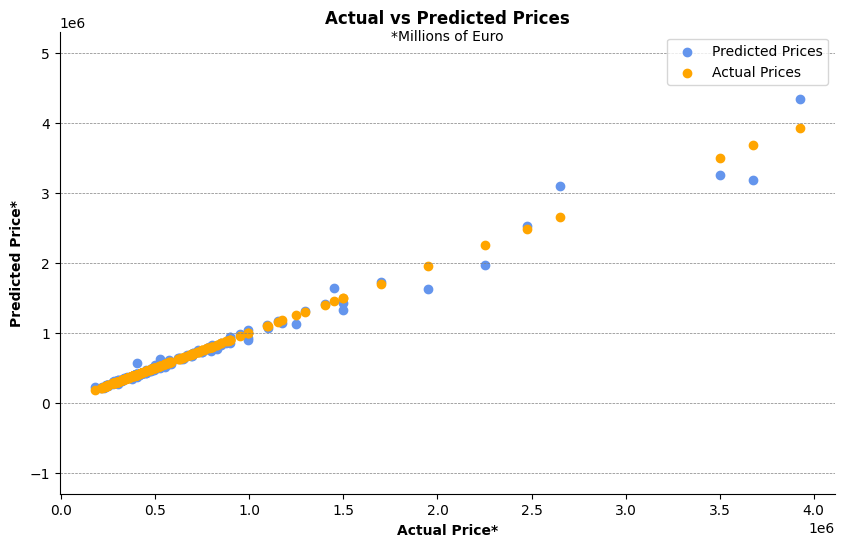

In [9]:
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted prices
plt.scatter(y_test, predicted_price, color='cornflowerblue', label='Predicted Prices')

# Scatter plot of actual prices
plt.scatter(y_test, y_test, color='orange', label='Actual Prices')

plt.xlabel('Actual Price*',weight='bold')
plt.ylabel('Predicted Price*', weight='bold')
plt.title('Actual vs Predicted Prices', weight='bold')
plt.text(0.5, 0.99, '*Millions of Euro', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.legend()
# Get the current axis
ax = plt.gca()
for tick in plt.gca().get_yticks():
    plt.axhline(y=tick, color='grey', linestyle='--', linewidth=0.5)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


## Summary
The Gradient Boosting Regressor was identified as the best model with an R2 score of 0.8730.
Training accuracy: 0.9989
Testing accuracy: 0.9808
This project demonstrates the process of exploring, processing, modeling, and evaluating data to predict house prices in Amsterdam.